In [ ]:
# TODO add black/white tophat as option
# TODO 

In [7]:
%matplotlib notebook

import numpy as np
import pandas as pd
from matplotlib import image
from matplotlib import pyplot as plt
from matplotlib.colors import rgb_to_hsv
from skimage.morphology import skeletonize
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation
from skimage.feature import canny
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import cv2
import os

In [2]:
data_dir = "../data"

In [3]:
#don't use this
def load_batch_rgb(red_percentile=99.95, green_percentile=90, blue_percentile=90):
    for folder in os.listdir(data_dir):
        folder = data_dir + "/" + folder
        r = np.zeros((1000,1000), dtype=bool)
        for imgPath in os.listdir(folder):
            imgPath = folder + "/" + imgPath
            img = image.imread(imgPath)
            r += np.logical_and(img[:,:,0] > np.percentile(img[:,:,0], red_percentile), 
                                np.logical_and(img[:,:,1] < np.percentile(img[:,:,1], green_percentile),
                                img[:,:,2] < np.percentile(img[:,:,2], blue_percentile)))
        yield r, folder

In [4]:
def load_batch_hsv():
    for folder in os.listdir(data_dir):
        folder = data_dir + "/" + folder
        r = np.zeros((1000,1000), dtype=np.uint8)
        compImg = np.zeros((1000,1000,3), dtype=np.uint8)
        for imgPath in os.listdir(folder):
            imgPath = folder + "/" + imgPath
            img = cv2.imread(imgPath)
            tmp = img.copy()
            # histogram equalization stuff
            img[:,:,0] = cv2.equalizeHist(img[:,:,0])
            img[:,:,1] = cv2.equalizeHist(img[:,:,1])
            img[:,:,2] = cv2.equalizeHist(img[:,:,2])
            compImg += (img / len(os.listdir(folder))).astype(np.uint8)
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            #this is used to generate the mask, has range of hsv values inside
            mask1 = cv2.inRange(hsv, (0, 0, 0), (20, 255, 255))
            mask2 = cv2.inRange(hsv, (160, 0, 0), (180, 255, 255))
            mask = cv2.bitwise_or(mask1, mask2)
            r = cv2.bitwise_or(r, mask)
        yield mask, folder, tmp

In [5]:
# create instance of loader, initialize ui state
vis_batch_loader = load_batch_hsv()
current = next(vis_batch_loader)
current_img = current[0]
original_img = current[0]
current_folder = current[1]

<IPython.core.display.Javascript object>


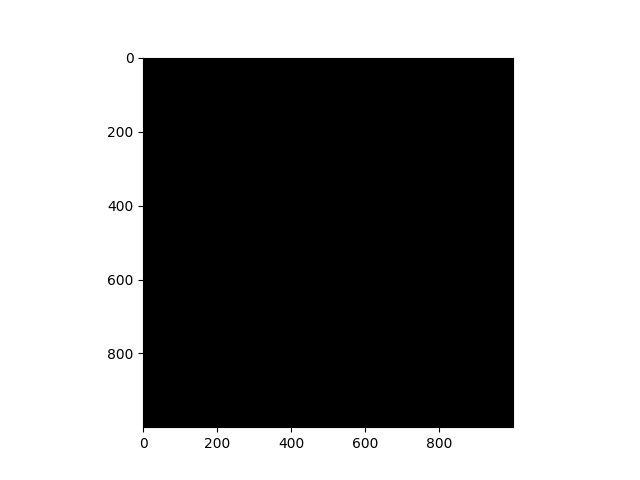

In [6]:
# ui stuff, just run the whole notebook and then you'll get a bunch 
# of buttons under this cell along with a plt plot of the masked image
# buttons will apply various morphological operations to the mask, changing the image
# reset will reset mask to original state
# textbox contains current folder, not changeable

def next_image(b):
    global current
    global original_img
    current = next(vis_batch_loader)
    current_img = current[0]
    original_img = current_img
    current_folder = current[1]
    folder_text.value = current_folder
    plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=current[0]), cv2.COLOR_BGR2RGB))
    
def reset_image(b):
    global current
    global original_img
    current = (original_img, current_folder, current[2])
    plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=original_img), cv2.COLOR_BGR2RGB))
    
def skeletonize_image(b):
    global current
    current_img = skeletonize(current[0]).astype(np.uint8)
    current_folder = current[1]
    current = (current_img, current_folder, current[2])
    plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=current_img), cv2.COLOR_BGR2RGB))

def binary_erode_image(b):
    global current
    current_img = binary_erosion(current[0]).astype(np.uint8)
    current_folder = current[1]
    current = (current_img, current_folder, current[2])
    plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=current_img), cv2.COLOR_BGR2RGB))
    
def binary_dilate_image(b):
    global current
    current_img = binary_dilation(current[0]).astype(np.uint8)
    current_folder = current[1]
    current = (current_img, current_folder, current[2])
    plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=current_img), cv2.COLOR_BGR2RGB))

def apply_canny(b):
    global current
    current_img = canny(current[0]).astype(np.uint8)
    current_folder = current[1]
    current = (current_img, current_folder, current[2])
    plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=current_img), cv2.COLOR_BGR2RGB))

def reverse_mask(b):
    global current
    current_img = np.logical_not(current[0]).astype(np.uint8)
    current_folder = current[1]
    current = (current_img, current_folder, current[2])
    plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=current_img), cv2.COLOR_BGR2RGB))
    
next_button = widgets.Button(
    description='Next Image',
    disabled=False,
    icon='arrow-right'
)
next_button.on_click(next_image)

reset_button = widgets.Button(
    description='Reset Mask',
    disabled=False,
    icon='redo'
)
reset_button.on_click(reset_image)

skeletonize_button = widgets.Button(
    description='Skeletonize Mask',
    disabled=False,
)
skeletonize_button.on_click(skeletonize_image)

binary_erode_button = widgets.Button(
    description='Binary Erode Mask',
    disabled=False,
)
binary_erode_button.on_click(binary_erode_image)

binary_dilate_button = widgets.Button(
    description='Binary Dilate Mask',
    disabled=False,
)
binary_dilate_button.on_click(binary_dilate_image)

canny_button = widgets.Button(
    description='Apply Canny to Mask',
    disabled=False,
)
canny_button.on_click(apply_canny)

reverse_button = widgets.Button(
    description='Reverse Mask',
    disabled=False,
)
reverse_button.on_click(reverse_mask)

folder_text = widgets.Text(
    value=current_folder,
)

display(widgets.VBox([
    widgets.HBox([
        next_button,
        reset_button,
        reverse_button,
        folder_text
    ]),
    widgets.HBox([
        binary_erode_button,
        binary_dilate_button,
        canny_button,
        skeletonize_button
    ]),
]))

plt.imshow(cv2.cvtColor(cv2.bitwise_and(current[2], current[2], mask=current_img), cv2.COLOR_BGR2RGB))
